In [1]:
import networkx as nx
import re
import numpy as np
import itertools
from timeit import default_timer as timer

In [2]:
def get_input(name):
    with open(f'{name}.txt') as f:
        return f.read().split('\n')

In [3]:
x = get_input('input')

In [4]:
x

['Valve XB has flow rate=0; tunnels lead to valves WZ, LE',
 'Valve BM has flow rate=0; tunnels lead to valves PL, RI',
 'Valve GC has flow rate=0; tunnels lead to valves HN, IT',
 'Valve RM has flow rate=0; tunnels lead to valves ZQ, YL',
 'Valve ZM has flow rate=5; tunnels lead to valves SN, KE, UW, MY, GW',
 'Valve UH has flow rate=0; tunnels lead to valves HM, HN',
 'Valve GW has flow rate=0; tunnels lead to valves LE, ZM',
 'Valve HN has flow rate=19; tunnels lead to valves UW, UH, GL, WZ, GC',
 'Valve VT has flow rate=0; tunnels lead to valves ZD, PE',
 'Valve VI has flow rate=0; tunnels lead to valves JS, AA',
 'Valve YL has flow rate=12; tunnels lead to valves PM, MH, RM, CM',
 'Valve LA has flow rate=0; tunnels lead to valves SN, IY',
 'Valve CM has flow rate=0; tunnels lead to valves YL, UL',
 'Valve JI has flow rate=24; tunnels lead to valves UV, WH, XW, OJ',
 'Valve ZD has flow rate=25; tunnels lead to valves VB, XW, VT',
 'Valve VB has flow rate=0; tunnels lead to valves Q

# Part 1

In [5]:
G = nx.empty_graph()
flow_rates = dict()
for valve in x:
    v = valve[6:8]
    flow = int(re.findall('rate=(.*);', valve)[0])
    flow_rates.update({v: flow})
    G.add_node(v)
    
    
    neighbors = re.findall('valve[s]? (.*)', valve)[0].split(', ')
    for n in neighbors:
        G.add_edge(v, n)

In [6]:
nx.set_node_attributes(G, flow_rates, 'flow')

In [7]:
pos = nx.spring_layout(G)

In [8]:
pos['AA']=np.array([-0.5,  -0.5])

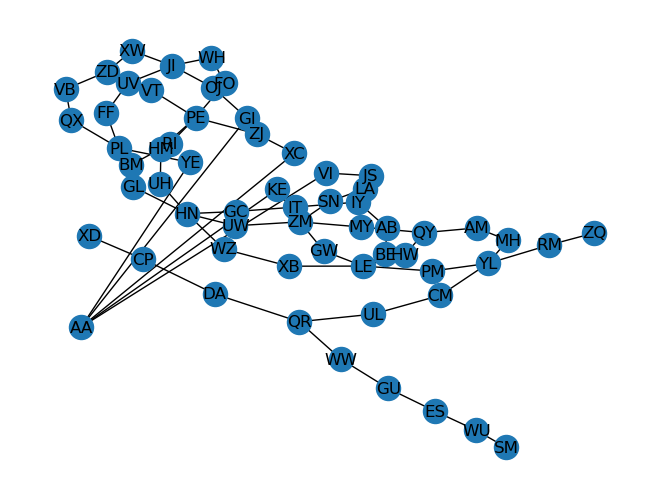

In [9]:
nx.draw(G, pos=pos, with_labels=True)

In [10]:
# nx.dijkstra_path_length(G, 'AA', 'HH')

In [11]:
# H = nx.DiGraph()
# for origin_node in G.nodes():
#     H.add_node(origin_node)
#     for destination_node in G.nodes():
#         if origin_node == destination_node:
#             continue
#         H.add_edge(origin_node, destination_node, 
#                    cost=nx.dijkstra_path_length(G, origin_node, destination_node)+1,
#                    reward=flow_rates[destination_node] )

In [12]:
H = nx.DiGraph()
for origin_node in G.nodes():
    if (origin_node != 'AA') and not flow_rates[origin_node]:
        continue
    H.add_node(origin_node)
    for destination_node in G.nodes():
        if origin_node == destination_node:
            continue
        if not flow_rates[destination_node]:
            continue
        H.add_edge(origin_node, destination_node, 
                   cost=nx.dijkstra_path_length(G, origin_node, destination_node)+1,
                   reward=flow_rates[destination_node] )

In [13]:
from networkx.classes.function import path_weight

In [14]:
def path_reward(G, path, cost_field, reward_field):
    cost = 0
    reward = 0
    if not nx.is_path(G, path):
        raise nx.NetworkXNoPath("path does not exist")
    for node, nbr in nx.utils.pairwise(path):
        cost += G[node][nbr][cost_field]
        reward += (30 - cost)*G[node][nbr][reward_field]
    return reward

In [15]:
# path_reward(H, ['AA', 'DD', 'BB', 'JJ', 'HH', 'EE', 'CC'], cost_field='cost', reward_field='reward')

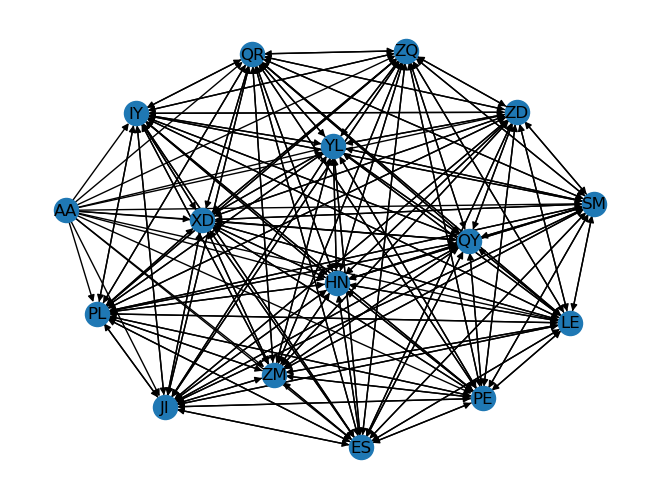

In [23]:
nx.draw(H, with_labels=True)

In [21]:
def find_best_path(G, path):
    if (unchecked_neighbors := [node for node in nx.neighbors(G, path[-1]) if node not in path]):
        return max([find_best_path(G, path+[node]) for node in unchecked_neighbors])
    else:
        return path_reward(G, path, cost_field='cost', reward_field='reward')

In [22]:
t0 = timer()
bp = find_best_path(H, ['AA'])
print(f'best path pressure: {bp}, time: {(timer()-t0)/60:.2f} min')

KeyboardInterrupt: 

In [ ]:
nodes_with_flow = [n for n in flow_rates.keys() if flow_rates[n]]
max_reward = 0
for p in itertools.permutations(nodes_with_flow):
    max_reward = max(max_reward, path_reward(H, ('AA',)+p, cost_field='cost', reward_field='reward'))
max_reward

# Ant Colony

In [ ]:
def traverse_graph(g, source_node = 0):
    ALPHA = 0.9
    BETA = 1.5
    visited = np.asarray([1 for _ in range(g.nodes)]) #originally no nodes have been visited
    visited[source_node] = 0 # except the initial/source node.

    cycle = [source_node]
    steps = 0
    current = source_node
    total_length = 0
    while steps < g.nodes -1:

        jumps_neighbors = []
        jumps_values = []
        for node in range(g.nodes):
            if visited[node] != 0:
                pheromone_level = max(g.intensity[current][node], 1e-5) #constant added to encourage exploration
                v = (pheromone_level**ALPHA ) / (g.distance[current][node]**BETA) 
                jumps_neighbors.append(node)
                jumps_values.append(v)

        next_node = random.choices(jumps_neighbors, weights = jumps_values)[0] # weighted (normalized) choice
       
        visited[next_node] = 0
        current = next_node
        cycle.append(current)
        steps+=1

    total_length = cycle_length(g, cycle) # just adds all the distances
    assert len(list(set(cycle))) == len(cycle)
    return cycle, total_length

# Part 2